In [1]:
import numpy as np
import pandas as pd
import GPy
import time
import sys
import os
import pdb
import matplotlib.pyplot as plt

from context import aep
from context import gpr
from context import load_data
from context import delete_blocks
from context import start_df
from context import save_df
from context import metrics
from thesis_work.plots import GP_figures
from thesis_work.plots import SGP_figures
from thesis_work.plots import DGP_figures

from baseline_models import full_GP_reg
from baseline_models import sparse_GP_reg
from aep_config import cont_optimization
from aep_config import aep_DGP_reg

default_dict = {'M': 50, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':100,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': []}
os.getcwd()
%matplotlib notebook

/Users/sergiopascualdiaz/mlsalt-code/geepee/geepee/


# Load data: normalise, delete blocks

Dataset size:  2500  Test size:  1000.0
Training:  1000


<IPython.core.display.Javascript object>


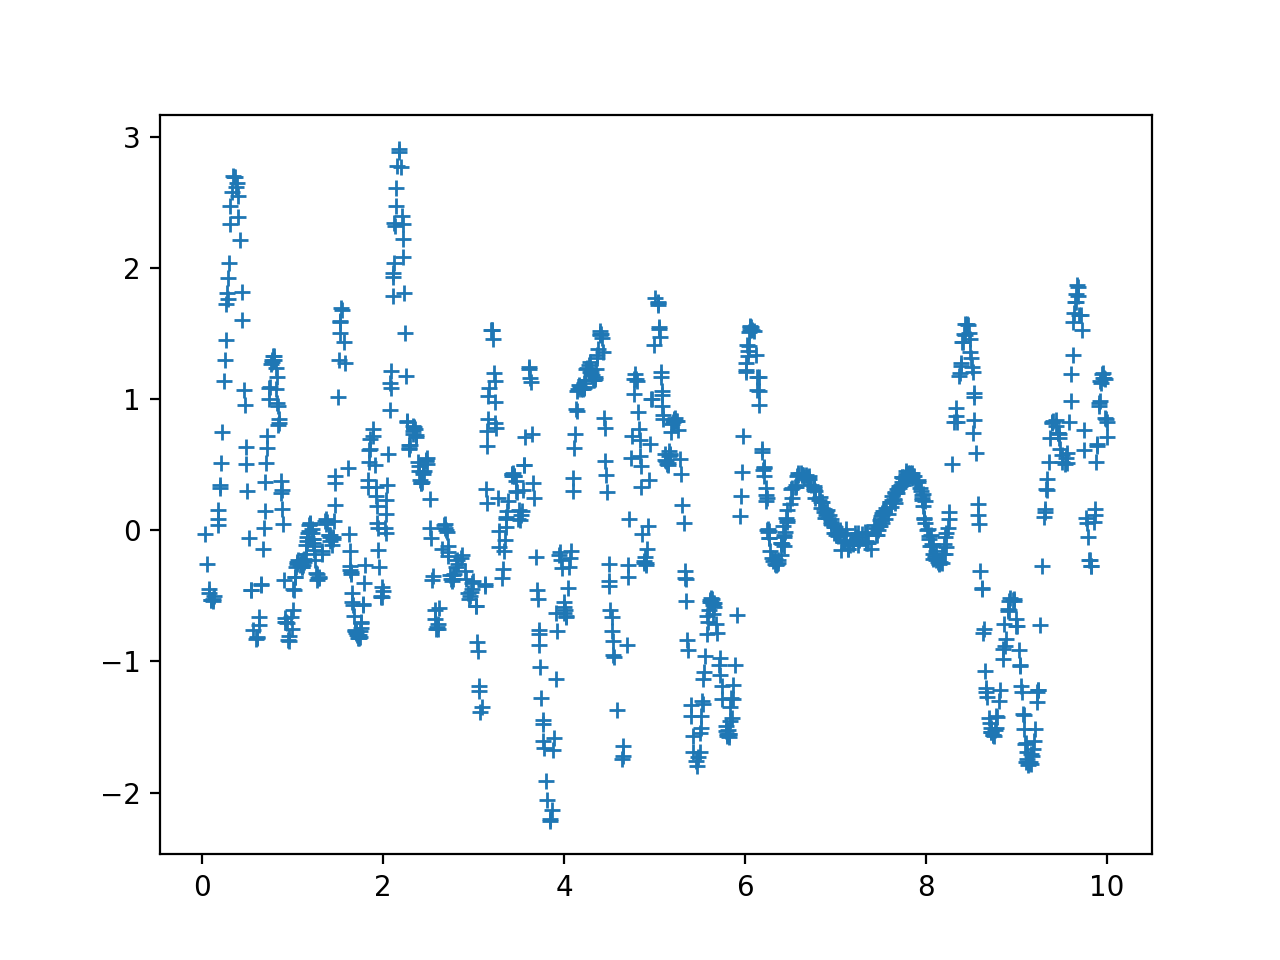

In [52]:
path = 'data/sample_5.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=1000, test=0.4, norm_out=False)
# X_test, y_test = delete_blocks(X_test, y_test,
#                                intervals=[2,4,8,9])
plt.figure()
plt.plot(X_test, y_test, '+')
plt.show()

## Sparse GP

create SGP model and optimize ...
Test MSE =0.057, NLL =0.086


<IPython.core.display.Javascript object>


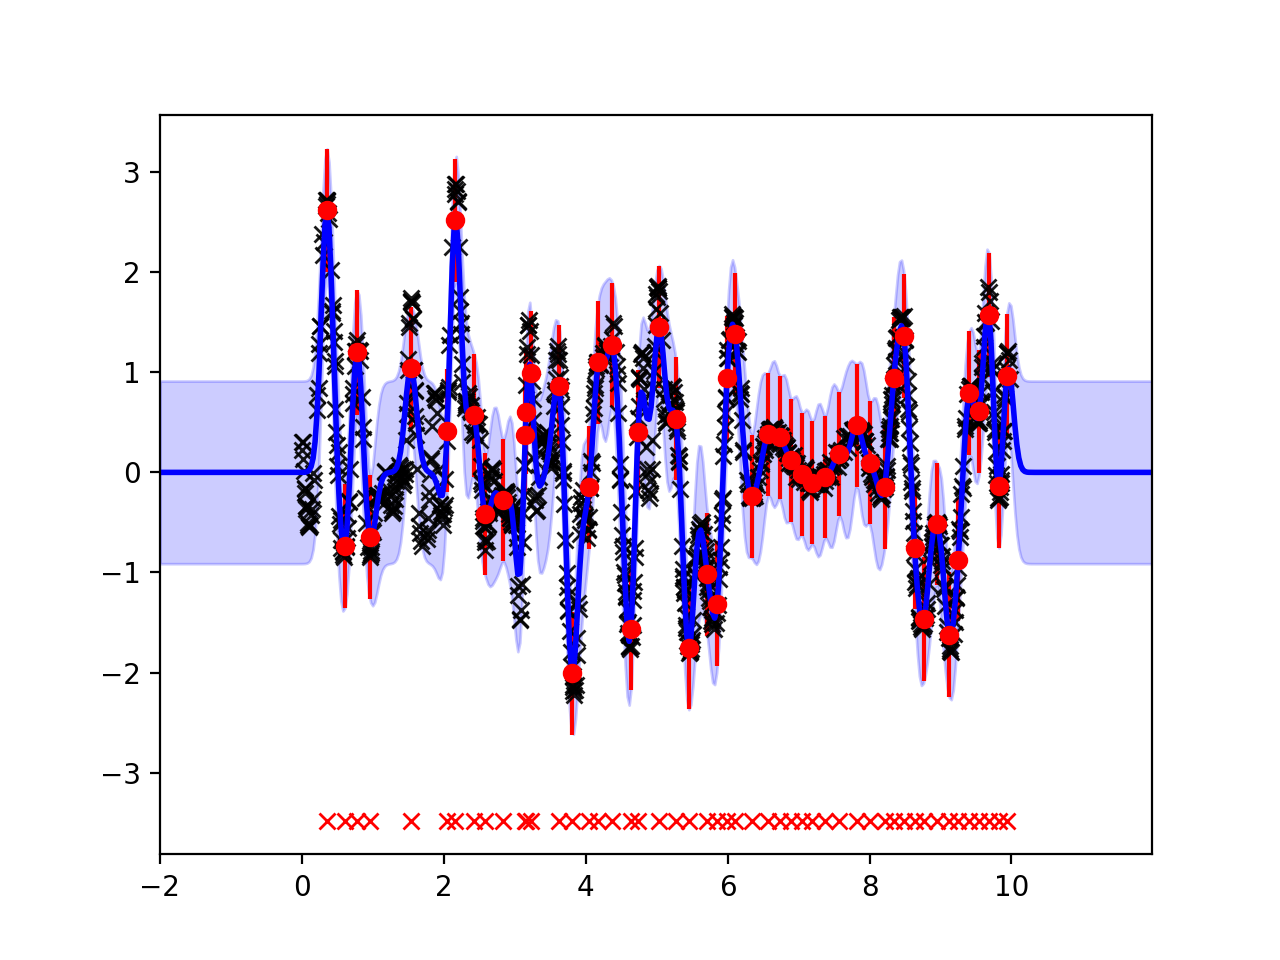

In [53]:
model_sgp, df = sparse_GP_reg(X_train, y_train, X_test, y_test, M=50)
fig = SGP_figures(model_sgp).plot()

# AEP Deep GPs

Create DGP model and optimize ...
Optimise with fixed:  ['zu_0']
SGP greedy initialisation
Perform sparse GP regression
sf_0
ls_0
zu_0
sn
iter 0 	 obj 1.479
iter 50 	 obj 1.299
iter 100 	 obj 1.038
iter 150 	 obj 0.989
iter 200 	 obj 0.851
iter 250 	 obj 0.938
iter 300 	 obj 0.731
iter 350 	 obj 0.682
iter 400 	 obj 0.685
iter 450 	 obj 0.667
iter 500 	 obj 0.723
iter 550 	 obj 0.606
Test MSE= 0.142, NLL= 0.343, SN= 0.306


<IPython.core.display.Javascript object>


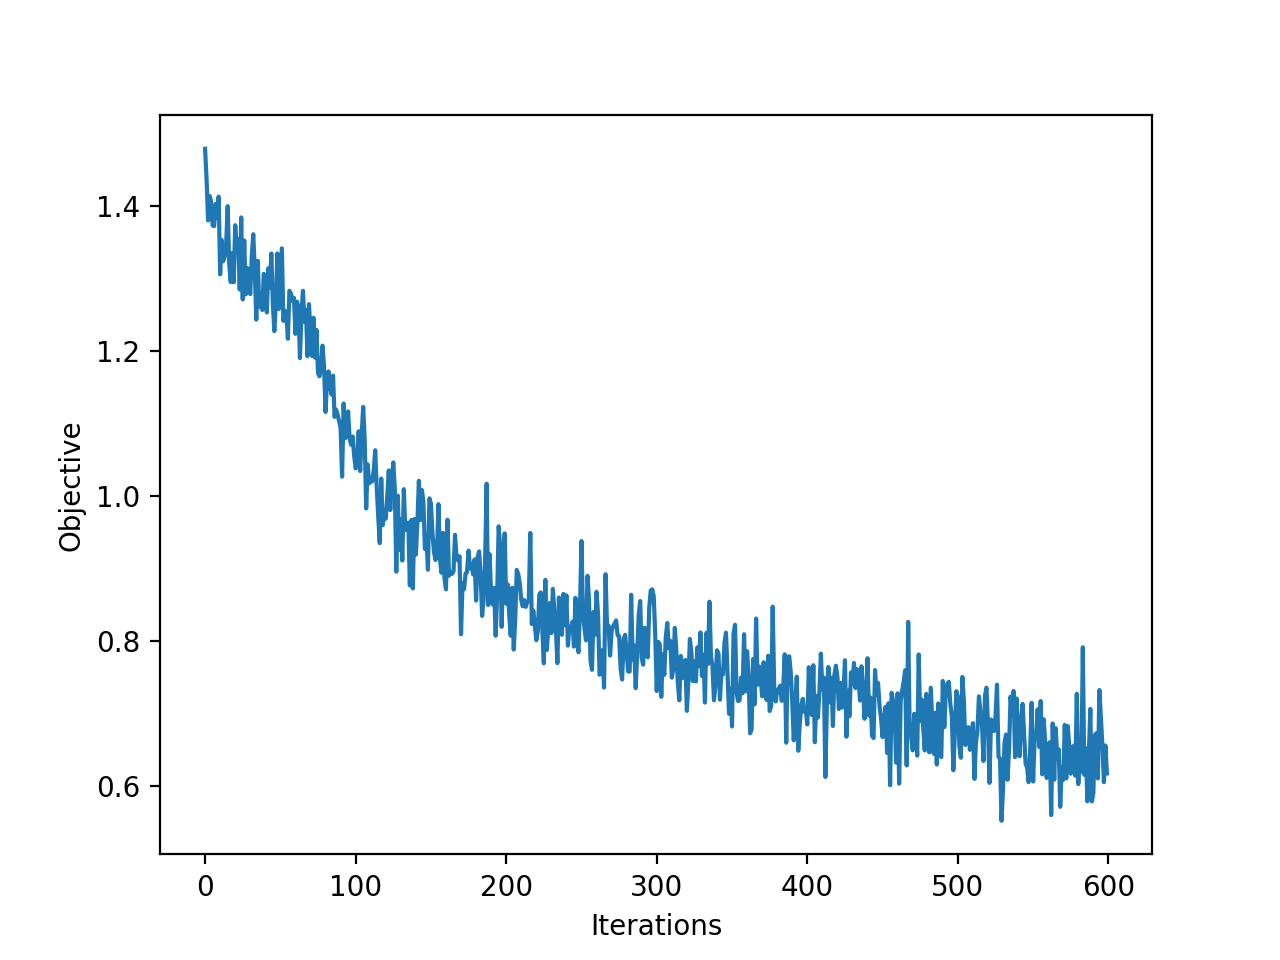

In [54]:
N_train = X_train.shape[0]
# ['zu_0', 'sf_0', 'ls_0', 'eta2_0', 'eta1_R_0']
config_dict = {'M': 50, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':600,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': ['zu_0'],
            'init_type':'greedy'}

model, df, costs = aep_DGP_reg(X_train, y_train, X_test, y_test, 
				conf_dict= config_dict,
				return_cost=True)
fig0 = DGP_figures(model,conf_dict=config_dict).plot_cost(costs)

In [58]:
config_dict2 = {'M': 50, 'hidden_size': [2], 
			'optimizer':'L-GBFS-B', 'max_it':1000,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': [],
            'init_type':'greedy'}
model, df = cont_optimization(model, X_test, y_test, conf_dict=config_dict2,
                              new_max_it=1000, return_cost=False)

L-BFGS-B iter  0  , obj  [ 0.33785153]
L-BFGS-B iter  50  , obj  [ 0.30650657]
L-BFGS-B iter  100  , obj  [ 0.30044999]
L-BFGS-B iter  150  , obj  [ 0.29281629]
Caught KeyboardInterrupt ...


IndexError: list index out of range

In [56]:
print dir(DGP_figures)

['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'h_out', 'h_out2', 'in_h', 'in_out', 'plot', 'plot_cost', 'plot_h_out', 'plot_hidden', 'plot_in_h', 'plot_init', 'plot_sample']


### Fitting plots

<IPython.core.display.Javascript object>


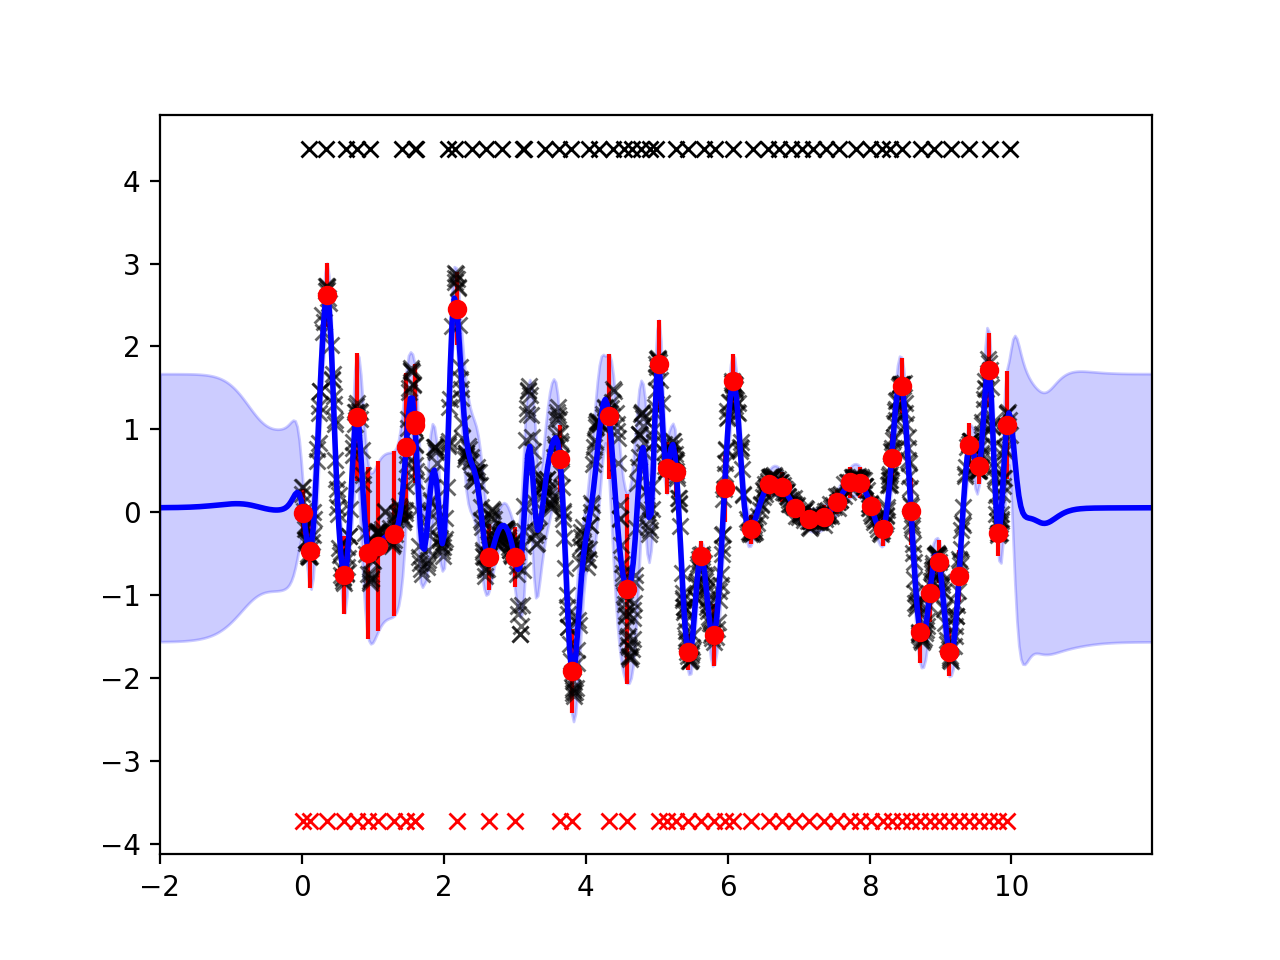

SGP greedy initialisation
Perform sparse GP regression
sf_0
ls_0
zu_0
sn


<IPython.core.display.Javascript object>


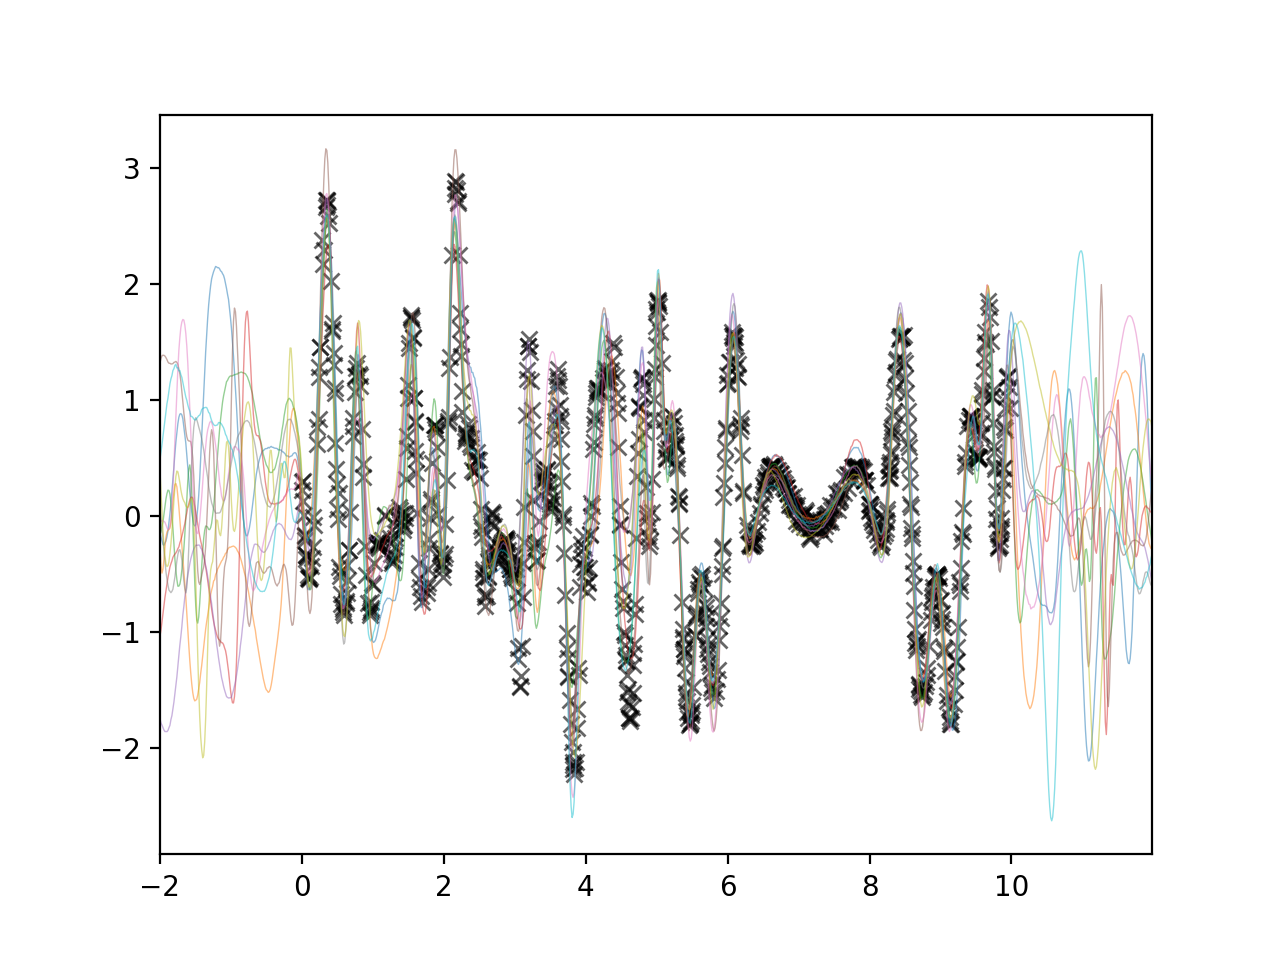

In [57]:
fig1 = DGP_figures(model, config_dict).plot()
fig2 = DGP_figures(model, config_dict).plot_sample()

### Hidden Layer

Default initialisation


<IPython.core.display.Javascript object>


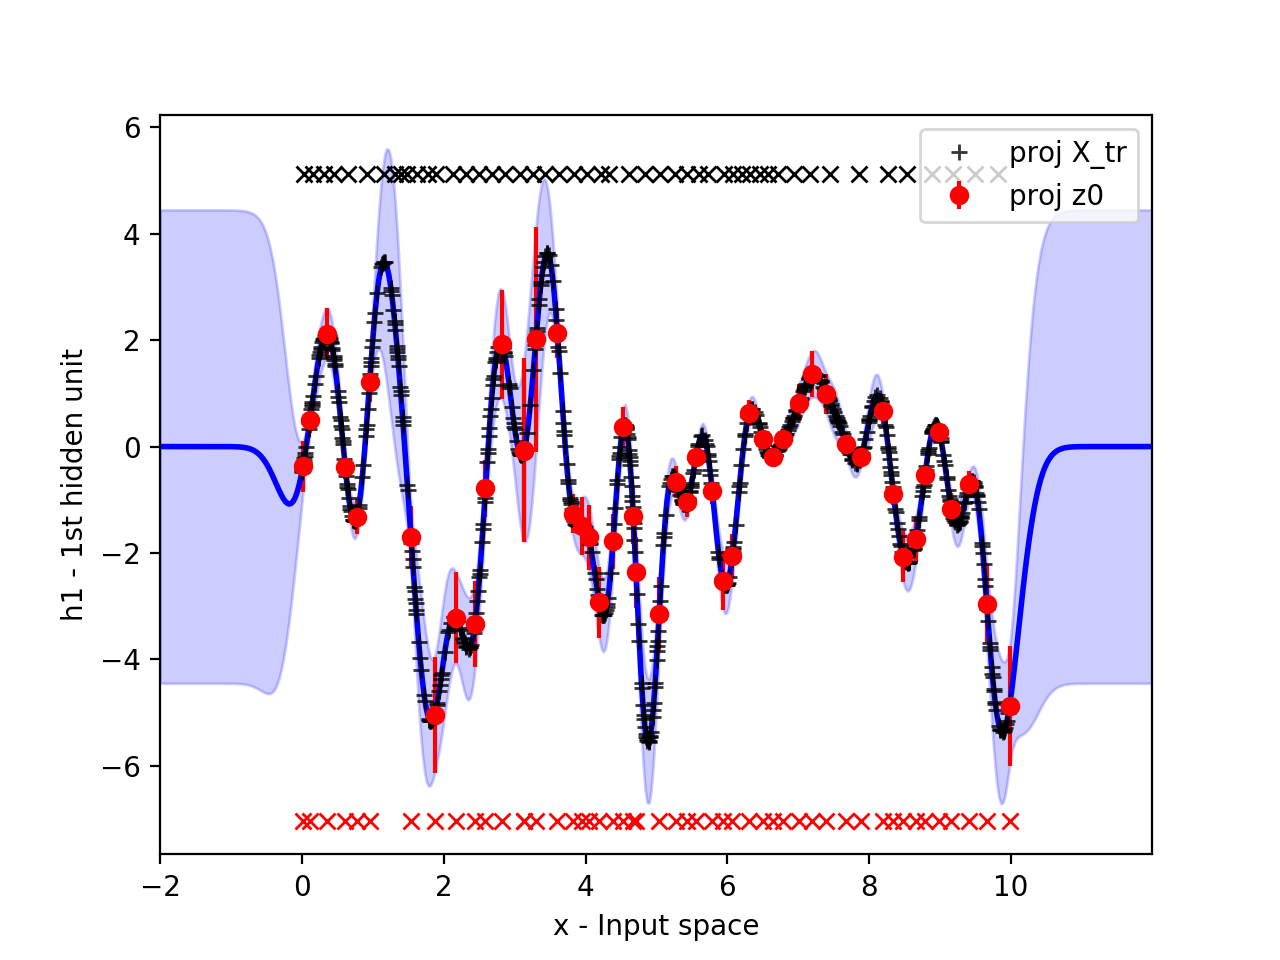

<IPython.core.display.Javascript object>


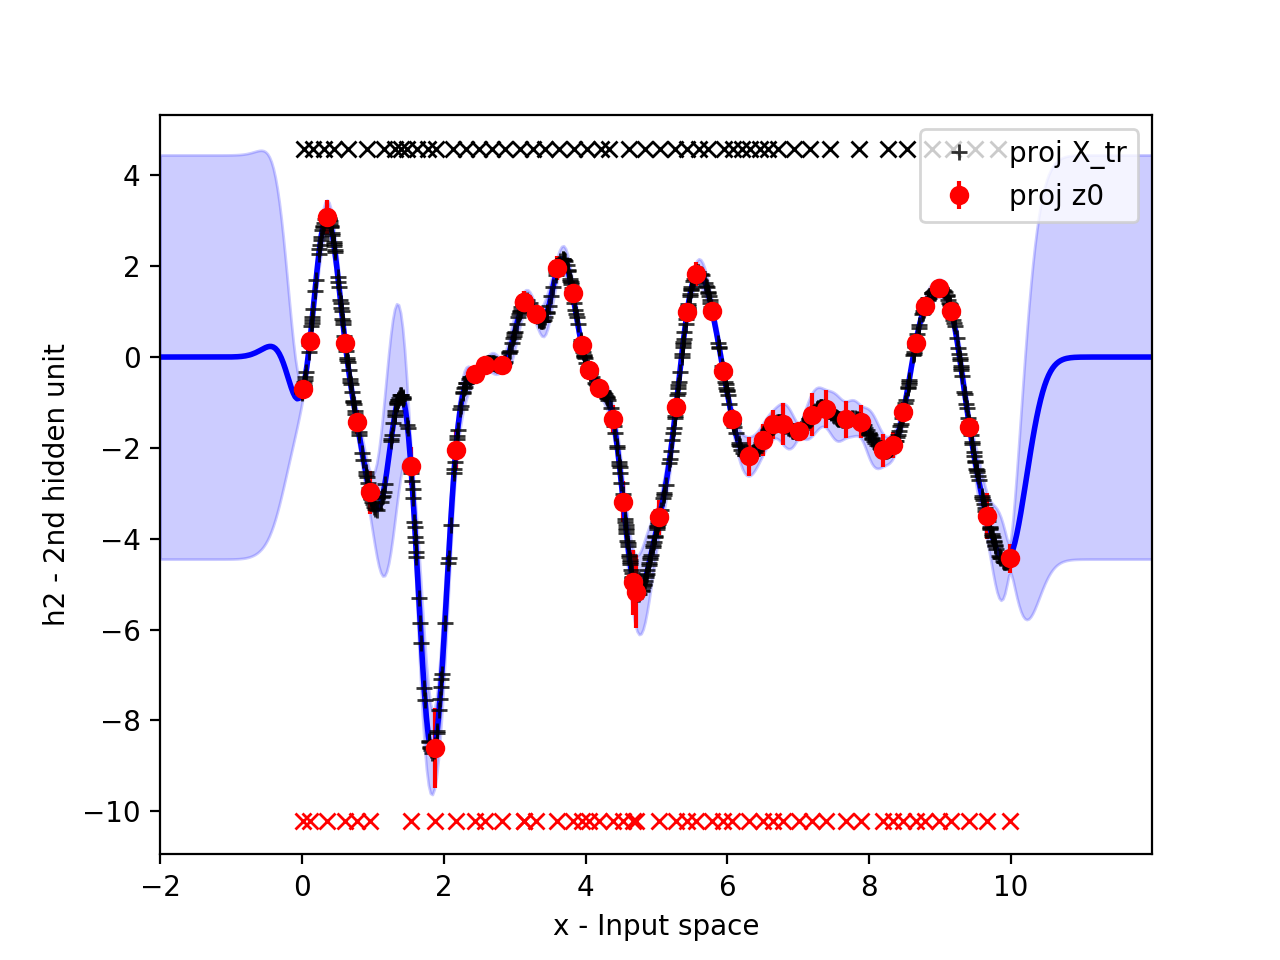

In [48]:
fig3 = DGP_figures(model, conf_dict=config_dict).plot_in_h()

Default initialisation


<IPython.core.display.Javascript object>


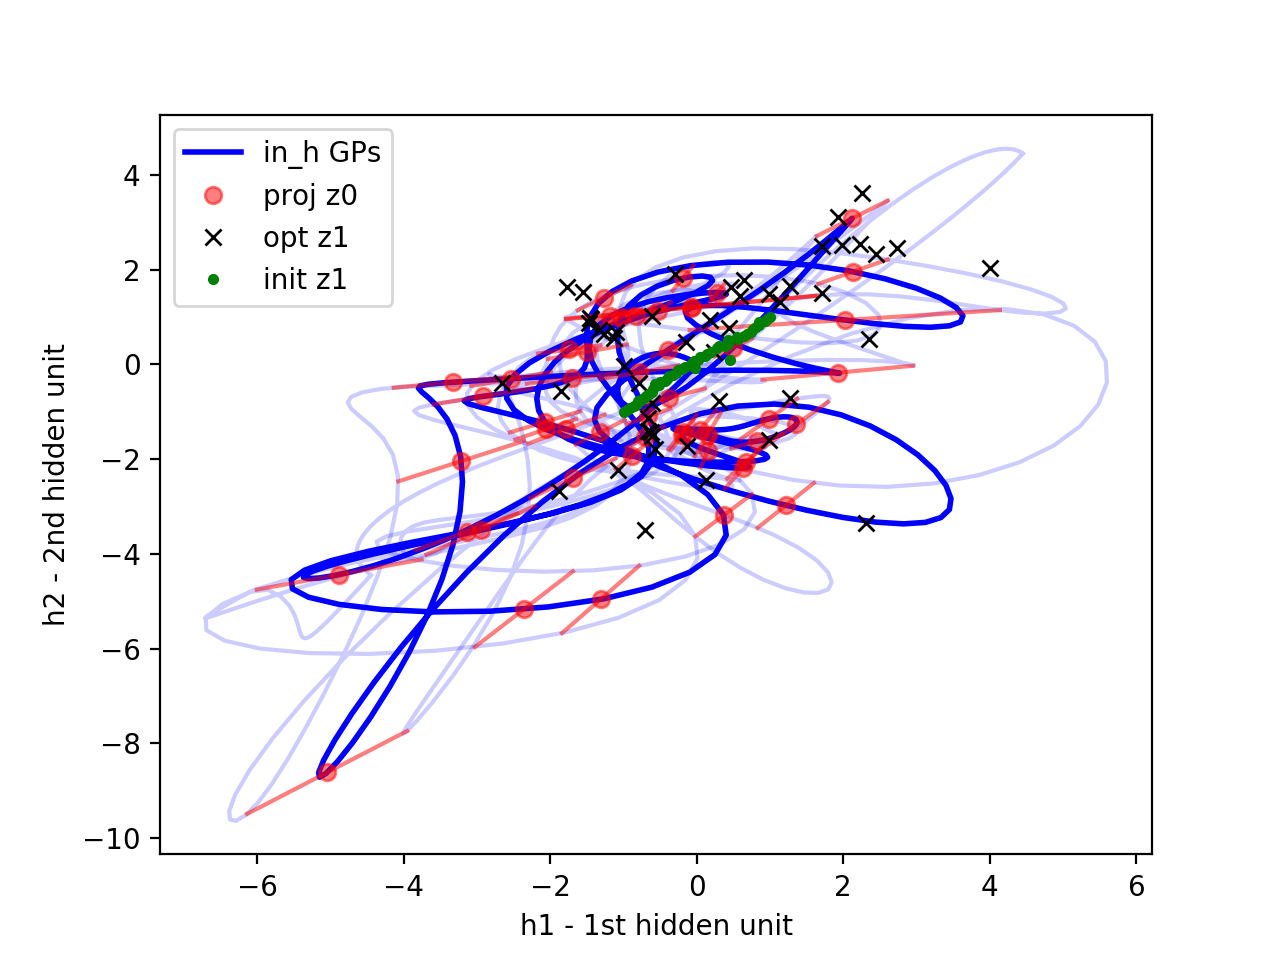

In [49]:
fig4 = DGP_figures(model, conf_dict=config_dict).plot_hidden()

Default initialisation


<IPython.core.display.Javascript object>


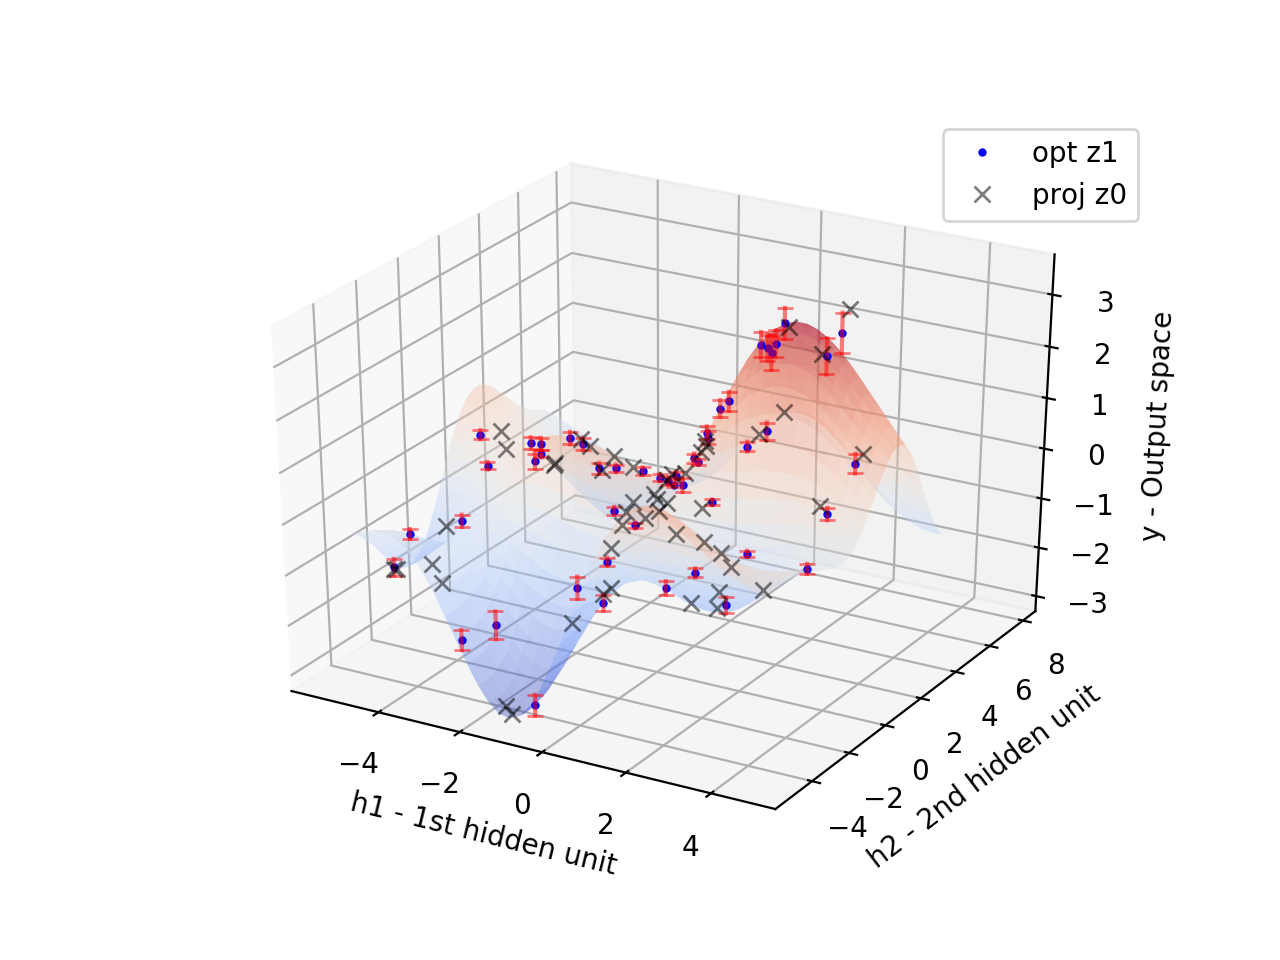

In [11]:
fig5 = DGP_figures(model, conf_dict=config_dict).plot_h_out()

### Initialisations

SGP greedy initialisation
Perform sparse GP regression
sf_0
ls_0
zu_0
sn


<IPython.core.display.Javascript object>


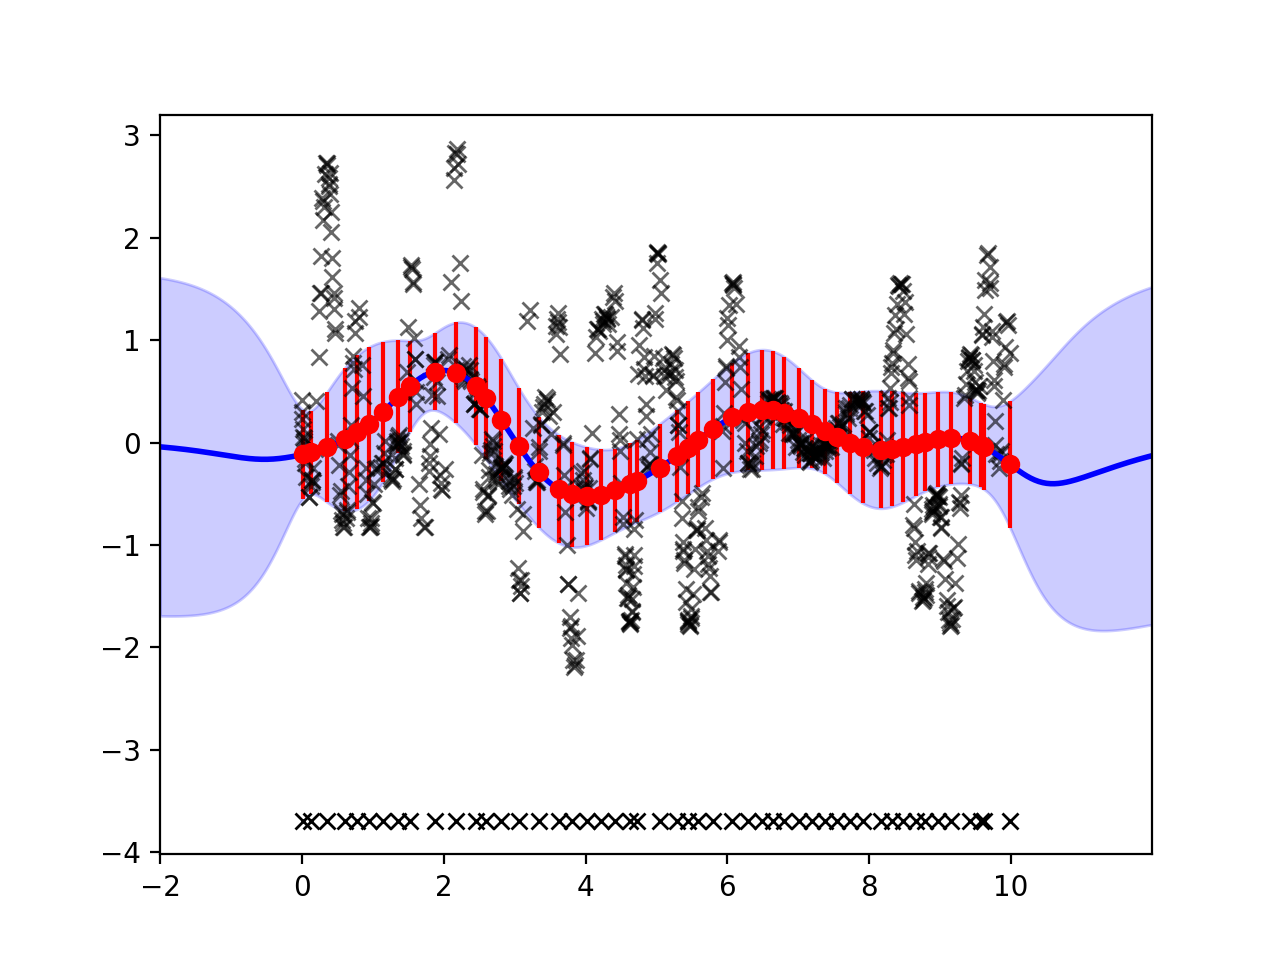

In [50]:
fig6 = DGP_figures(model, conf_dict=config_dict).plot_init()

# Baseline models

create full GP model and optimize ...
Test MSE =0.005, NLL =-1.267


<IPython.core.display.Javascript object>


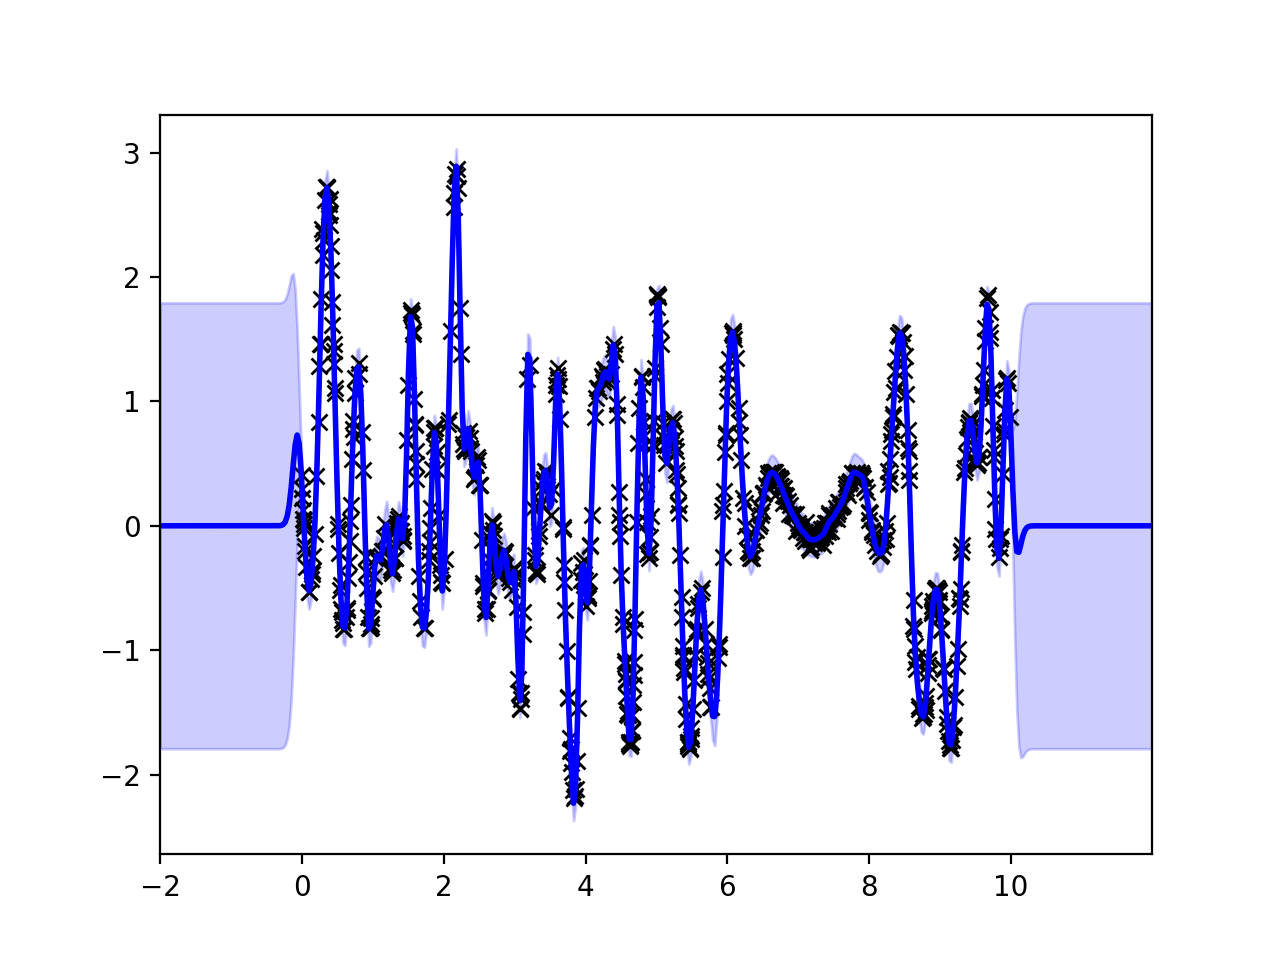

In [51]:
model_gp, df = full_GP_reg(X_train, y_train, X_test, y_test)
fig = GP_figures(model_gp).plot()

In [27]:
model_sgp = GPy.models.SparseGPRegression(X_train,y_train, kernel=GPy.kern.RBF(input_dim=1),num_inducing=50)
param = model_sgp.optimize('bfgs',messages=False)

In [28]:
zu = model_sgp.Z.values
sf = model_sgp.kern.variance.values
ls = model_sgp.kern.lengthscale.values

In [29]:
sn1 = model_sgp.likelihood.variance.values

In [30]:
def compute_kernel(lls, lsf, x, z):

    ls = np.exp(lls)
    sf = np.exp(lsf)

    if x.ndim == 1:
        x= x[ None, : ]

    if z.ndim == 1:
        z= z[ None, : ]

    r2 = cdist(x, z, 'seuclidean', V = ls)**2.0  
    k = sf * np.exp(-0.5*r2)
    return k
from scipy.spatial.distance import cdist
JITTER = 1e-5
M = 50
Dout = 1

In [31]:
Kuu = compute_kernel(2 * ls, 2 * sf, zu, zu)
Kuu += np.diag(JITTER * np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)

eta1_R = np.zeros((Dout, M * (M + 1) / 2))
eta2 = np.zeros((Dout, M))
for d in range(Dout):
    mu = np.linspace(-1, 1, M).reshape((M, 1))
    # mu += 0.01 * np.random.randn(M, 1)
    alpha = 0.5 * np.random.rand(M)
    # alpha = 0.1 * np.random.rand(M) # worse init obj = 44.2
    alpha = sn1 * np.random.rand(M)
    Su = np.diag(alpha)
    
    Suinv = np.diag(1 / alpha)
    theta2 = np.dot(Suinv, mu)
    # theta2 = np.dot(Suinv + Kuuinv, mu)
    theta1 = Suinv
    

    R = np.linalg.cholesky(theta1).T
    triu_ind = np.triu_indices(M)
    diag_ind = np.diag_indices(M)
    R[diag_ind] = np.log(R[diag_ind])
    eta1_d = R[triu_ind].reshape((M * (M + 1) / 2,))
    eta2_d = theta2.reshape((M,))
    eta1_R[d, :] = eta1_d
    eta2[d, :] = eta2_d

In [32]:
eta2.shape

(1, 50)

eta1_R

In [33]:
eta1_R.shape

(1, 1275)

In [34]:
model_dgp = aep.SDGPR(X_train, y_train, 50, hidden_sizes=[2], lik='Gaussian')
params0 = model_dgp.optimise(method='adam', maxiter=1)

Default initialisation
iter 0 	 obj 41.159


In [35]:
for i in params0.keys():
    print i, params0[i].shape, params0[i]

zu_1 (50, 2) [[-1.001      -0.999     ]
 [-0.96018367 -0.96018367]
 [-0.91736735 -0.91936735]
 [-0.87655102 -0.87855102]
 [-0.83573469 -0.83773469]
 [-0.79491837 -0.79691837]
 [-0.75410204 -0.75610204]
 [-0.71328571 -0.71528571]
 [-0.67246939 -0.67446939]
 [-0.63165306 -0.63365306]
 [-0.59083674 -0.59283673]
 [-0.55002041 -0.55002041]
 [-0.51120408 -0.50920408]
 [-0.47038776 -0.46838776]
 [-0.42957143 -0.42757143]
 [-0.3887551  -0.3867551 ]
 [-0.34793878 -0.34593878]
 [-0.30712245 -0.30512245]
 [-0.26430612 -0.26430612]
 [-0.2234898  -0.2234898 ]
 [-0.18267347 -0.18467347]
 [-0.14185714 -0.14385714]
 [-0.10104082 -0.10304082]
 [-0.06022449 -0.06222449]
 [-0.01940816 -0.02140816]
 [ 0.02140816  0.01940816]
 [ 0.06222449  0.06022449]
 [ 0.10304082  0.10104082]
 [ 0.14385714  0.14185714]
 [ 0.18467347  0.18267347]
 [ 0.2254898   0.2234898 ]
 [ 0.26630612  0.26430612]
 [ 0.30712245  0.30512245]
 [ 0.34793878  0.34593878]
 [ 0.3887551   0.3867551 ]
 [ 0.42957143  0.42757143]
 [ 0.47038776  

In [36]:
params1 = model_dgp.optimise(method='adam', maxiter=100, reinit_hypers=False)

iter 0 	 obj 39.928
iter 50 	 obj 7.400


In [37]:
for i in params1.keys():
    print i, params1[i].shape

zu_1 (50, 2)
zu_0 (50, 1)
sf_0 (1,)
sf_1 (1,)
sn ()
ls_0 (1,)
ls_1 (2,)
eta2_1 (1, 50)
eta2_0 (2, 50)
eta1_R_1 (1, 1275)
eta1_R_0 (2, 1275)


In [80]:
zu.shape

(50, 1)

In [86]:
sn.shape

(1,)